#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [130]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,8))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [39]:
data = pd.read_csv('data01_train.csv')
test = pd.read_csv('data01_test.csv')
print(data.shape)
print(test.shape)

(5881, 563)
(1471, 563)


In [41]:
print(data.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [45]:
data.drop(columns='subject', inplace = True)
test.drop(columns='subject', inplace = True)

In [53]:
print(data.shape)
print(test.shape)

(5881, 562)
(1471, 562)


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [49]:
data.shape

(5881, 562)

In [55]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [79]:
(data['Activity'].value_counts(normalize=True) *100).round(2)

Activity
LAYING                18.96
STANDING              18.48
SITTING               17.55
WALKING               16.97
WALKING_UPSTAIRS      14.59
WALKING_DOWNSTAIRS    13.45
Name: proportion, dtype: float64

### 1. 정적 활동
- **LAYING**
- **STANDING**
- **SITTING**

### 2. 동적 활동
- **WALKING**
- **WALKING_UPSTAIRS**
- **WALKING_DOWNSTAIRS**


### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# data로 x,y , train, val 생성


In [106]:
x = data.drop(columns='Activity')
y  = data.loc[:, 'Activity']

In [112]:
x.shape , y.shape

((5881, 561), (5881,))

In [114]:
# train, val 생성

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size= .2)

#### 2) 모델링

In [116]:
model = RandomForestClassifier()

model.fit(x_train, y_train)

RandomForestClassifier()

#### 3) 변수 중요도 추출

In [122]:
ip = model.feature_importances_
ip

array([1.64803012e-04, 4.36171064e-04, 1.71743000e-04, 3.49335849e-03,
       4.18047867e-04, 5.18845854e-04, 4.02041657e-03, 3.77818516e-04,
       2.20664608e-04, 1.26096887e-02, 2.36472063e-04, 2.05257014e-04,
       4.17448215e-04, 3.70362275e-04, 2.65004533e-04, 2.22603345e-03,
       3.14723730e-03, 2.25354933e-04, 4.28272347e-04, 1.24532691e-03,
       4.59264160e-04, 5.37726131e-04, 1.26793186e-03, 2.93925333e-04,
       3.17023297e-04, 1.40991390e-04, 1.71669604e-04, 1.92597349e-04,
       2.75111911e-04, 1.93901312e-04, 8.97705374e-05, 1.48494895e-04,
       2.04915912e-04, 3.15822718e-04, 9.58204910e-05, 1.70440426e-04,
       3.00422000e-04, 5.40416598e-03, 9.94404690e-04, 3.04055588e-03,
       2.49702206e-02, 3.17231177e-02, 7.56472454e-03, 9.73828504e-04,
       1.85541030e-03, 1.26361092e-03, 2.13013233e-03, 1.14486225e-03,
       5.84030359e-04, 2.32827099e-02, 1.68296843e-02, 8.52464496e-03,
       3.14929370e-02, 2.35533403e-02, 7.44583680e-03, 3.44042565e-03,
      

In [136]:
plot_feature_importance(ip, x_train.columns,result_only=True).head(5)

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.032347
1,tGravityAcc-mean()-Y,0.031723
2,tGravityAcc-min()-X,0.031493
3,"angle(Y,gravityMean)",0.029874
4,tGravityAcc-energy()-X,0.027398


In [138]:
plot_feature_importance(ip, x_train.columns,result_only=True).tail(5)

,feature_name,feature_importance
556,"tBodyAcc-arCoeff()-Y,2",0.000090
557,fBodyBodyGyroJerkMag-maxInds,0.000084
558,"fBodyAccJerk-bandsEnergy()-49,56.1",0.000080
559,tBodyAccMag-arCoeff()4,0.000074
560,"angle(tBodyAccMean,gravity)",0.000071


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [140]:
h5 = plot_feature_importance(ip, x_train.columns,result_only=True).head(5)
h5

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.032347
1,tGravityAcc-mean()-Y,0.031723
2,tGravityAcc-min()-X,0.031493
3,"angle(Y,gravityMean)",0.029874
4,tGravityAcc-energy()-X,0.027398


In [233]:
t5 = plot_feature_importance(ip, x_train.columns,result_only=True).tail(5)
t5

,feature_name,feature_importance
556,"tBodyAcc-arCoeff()-Y,2",0.000090
557,fBodyBodyGyroJerkMag-maxInds,0.000084
558,"fBodyAccJerk-bandsEnergy()-49,56.1",0.000080
559,tBodyAccMag-arCoeff()4,0.000074
560,"angle(tBodyAccMean,gravity)",0.000071


#### 2) 상위 5개 변수에 대한 분석

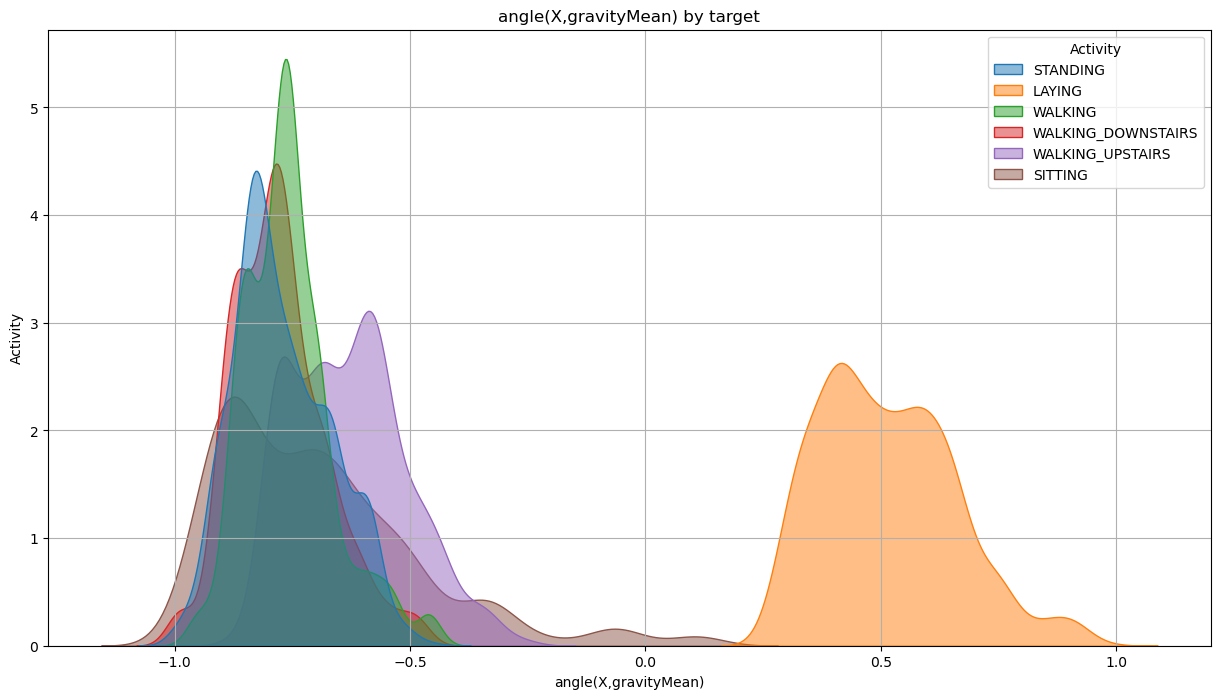

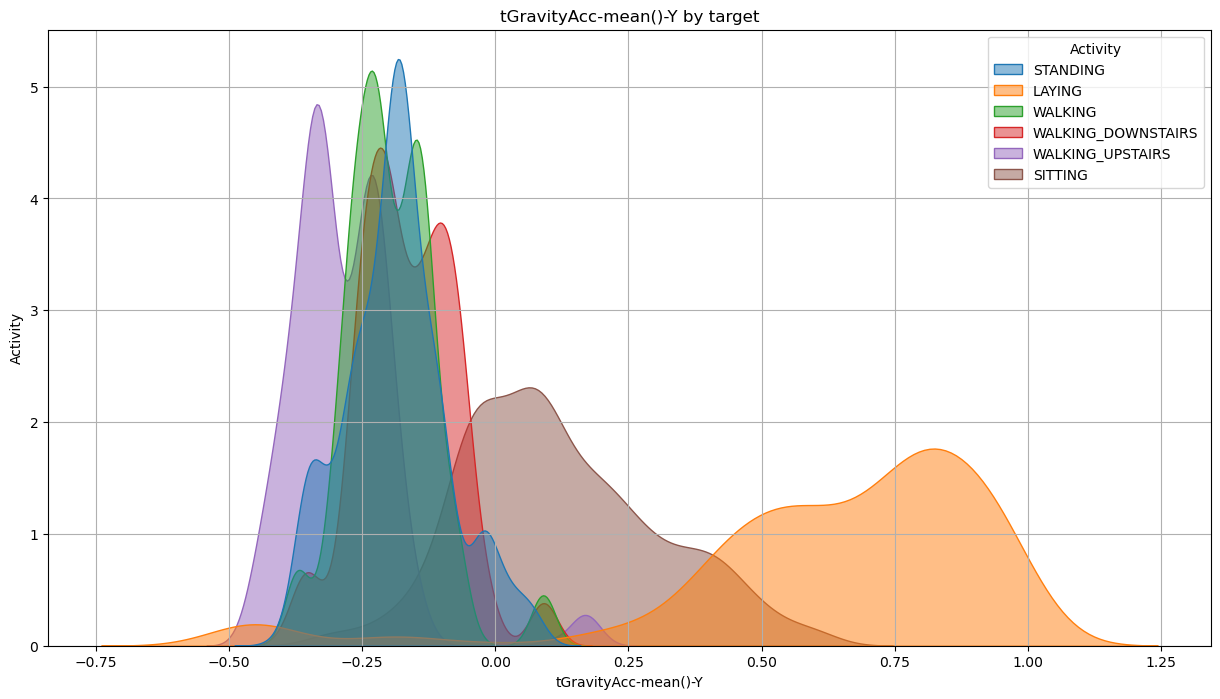

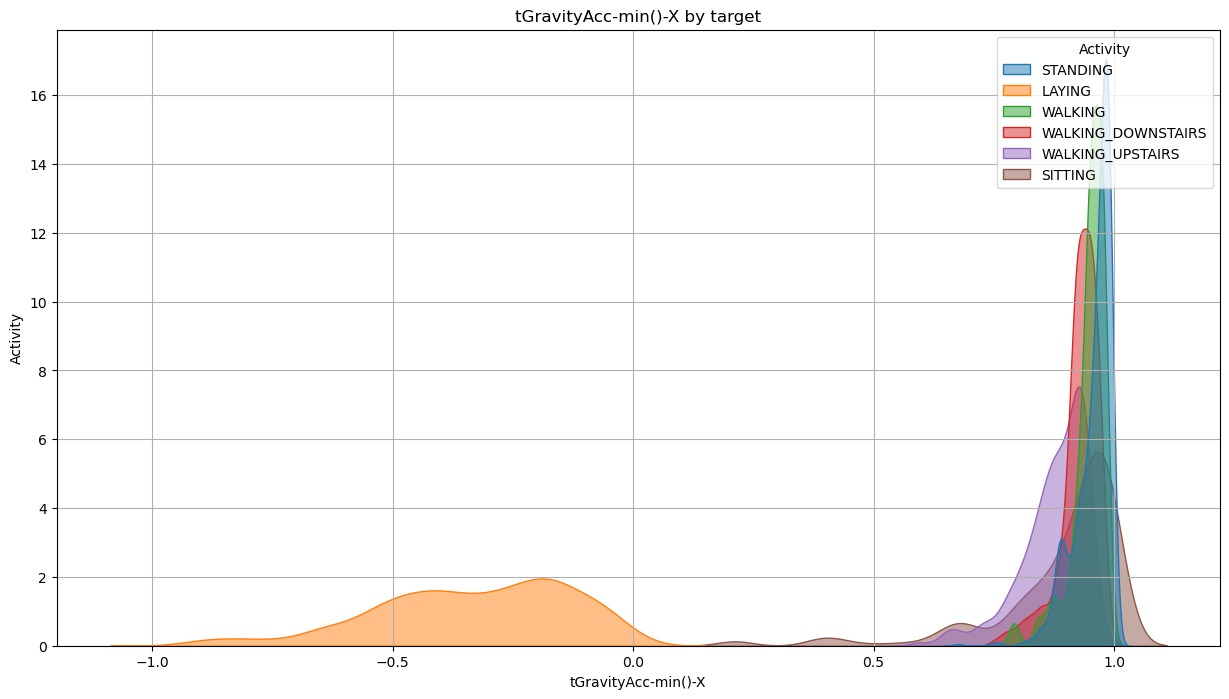

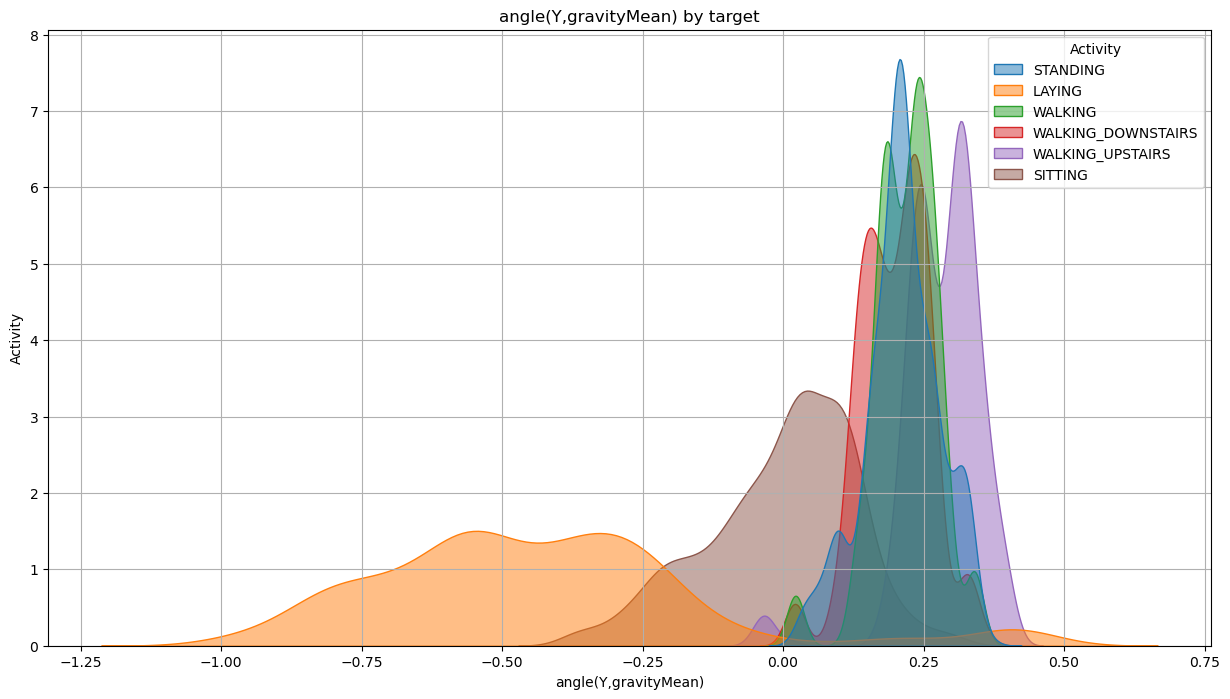

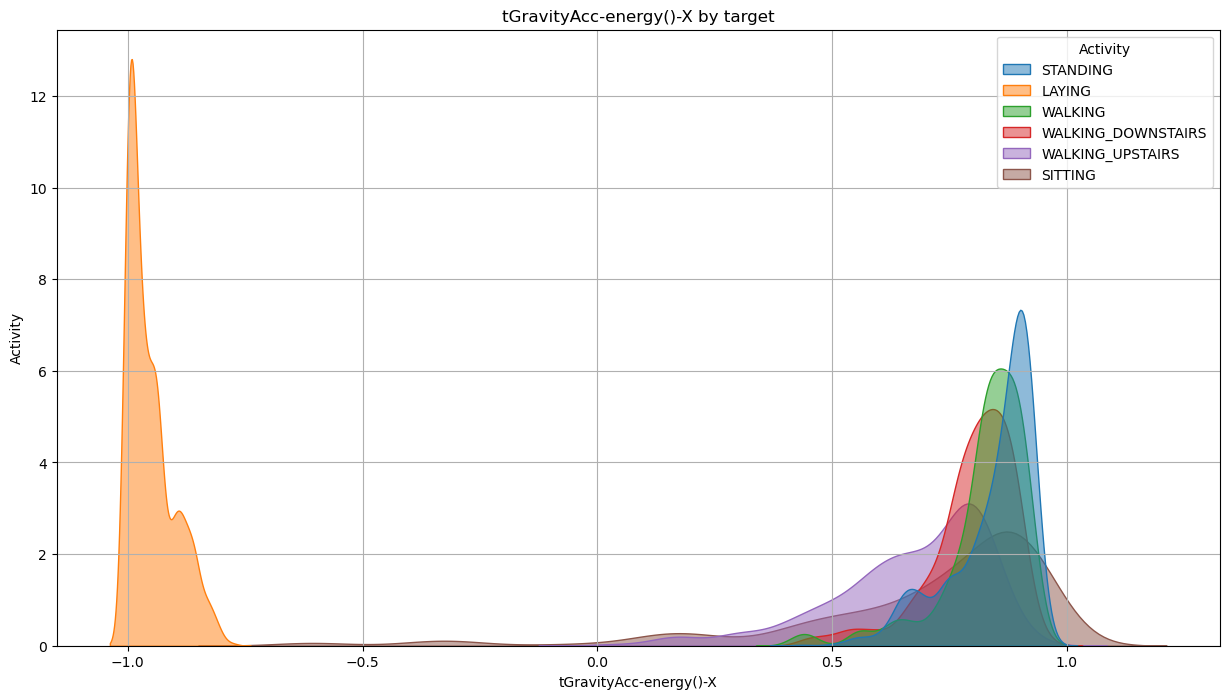

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in h5['feature_name']:
    plt.figure(figsize=(15, 8))  
    sns.kdeplot(data=x_train, x=feature, hue=y, fill = True, common_norm=False, alpha=0.5)
    plt.title(f'{feature} by target')
    plt.xlabel(feature)
    plt.ylabel('Activity')
    plt.grid()
    plt.show()  

#### 3) 하위 5개 변수에 대한 분석

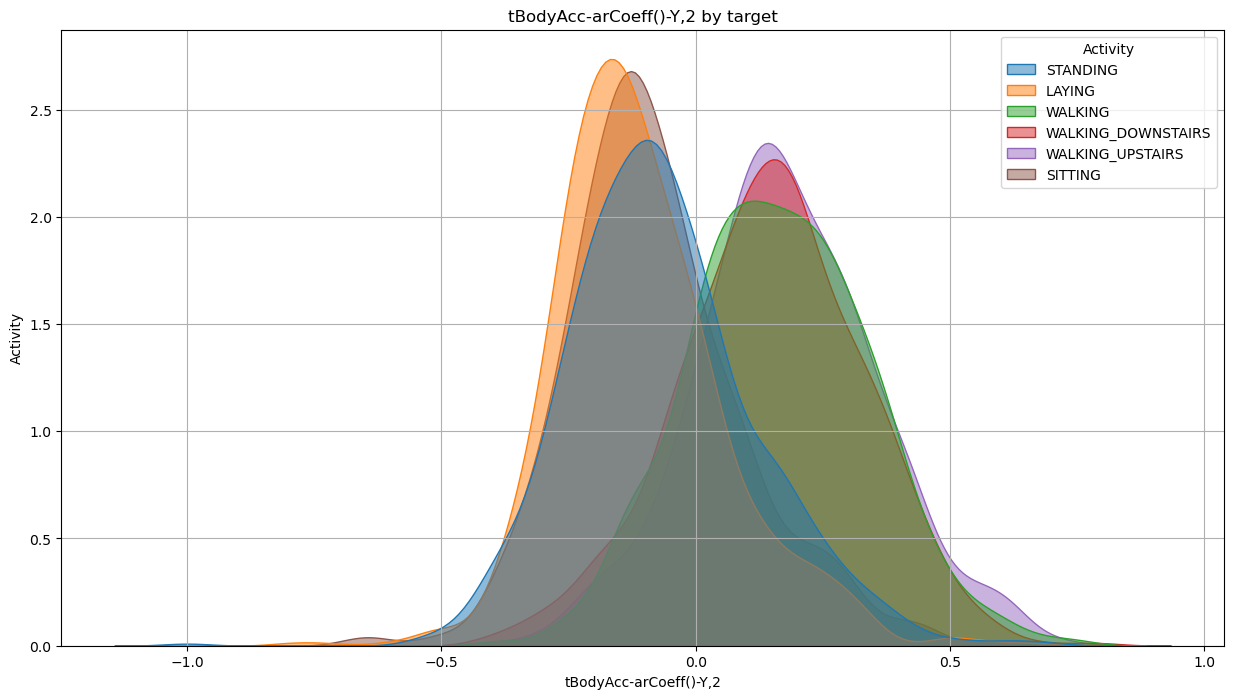

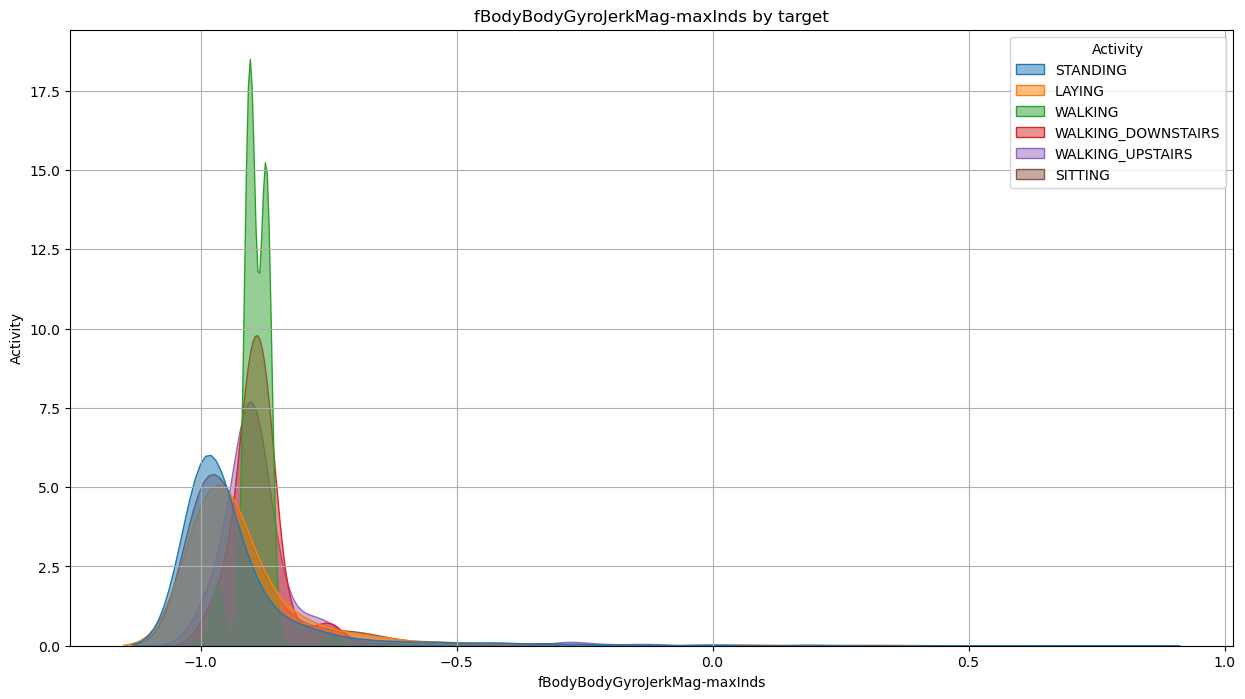

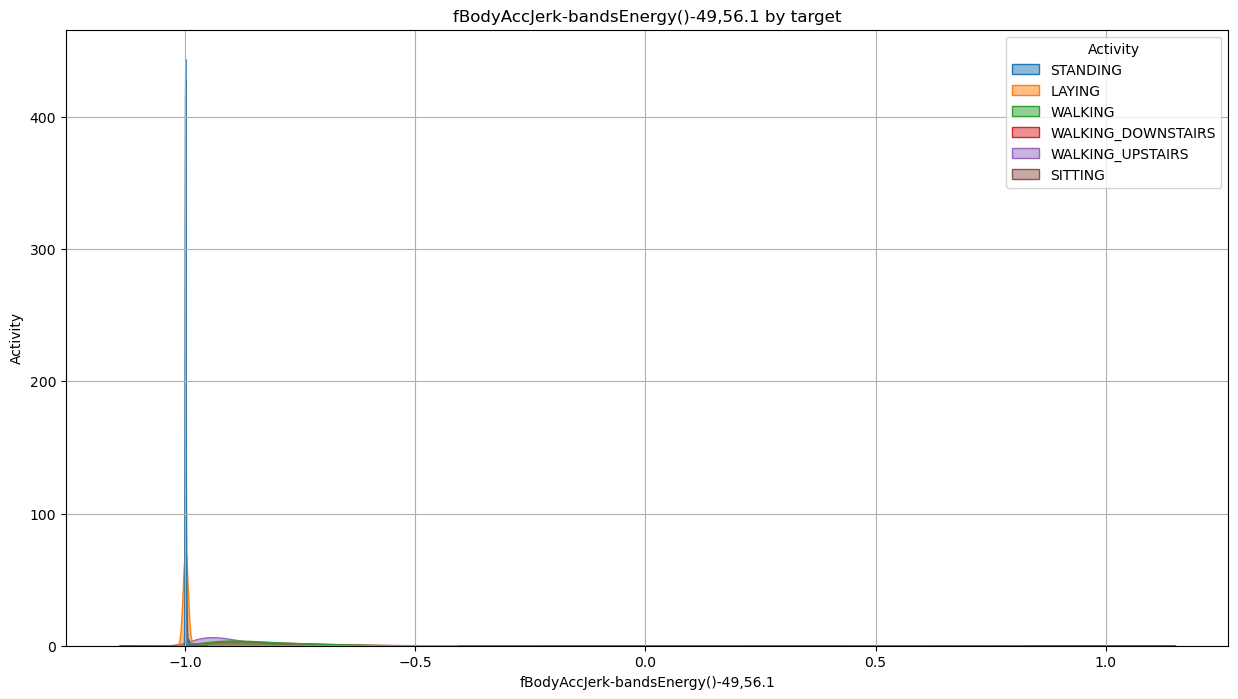

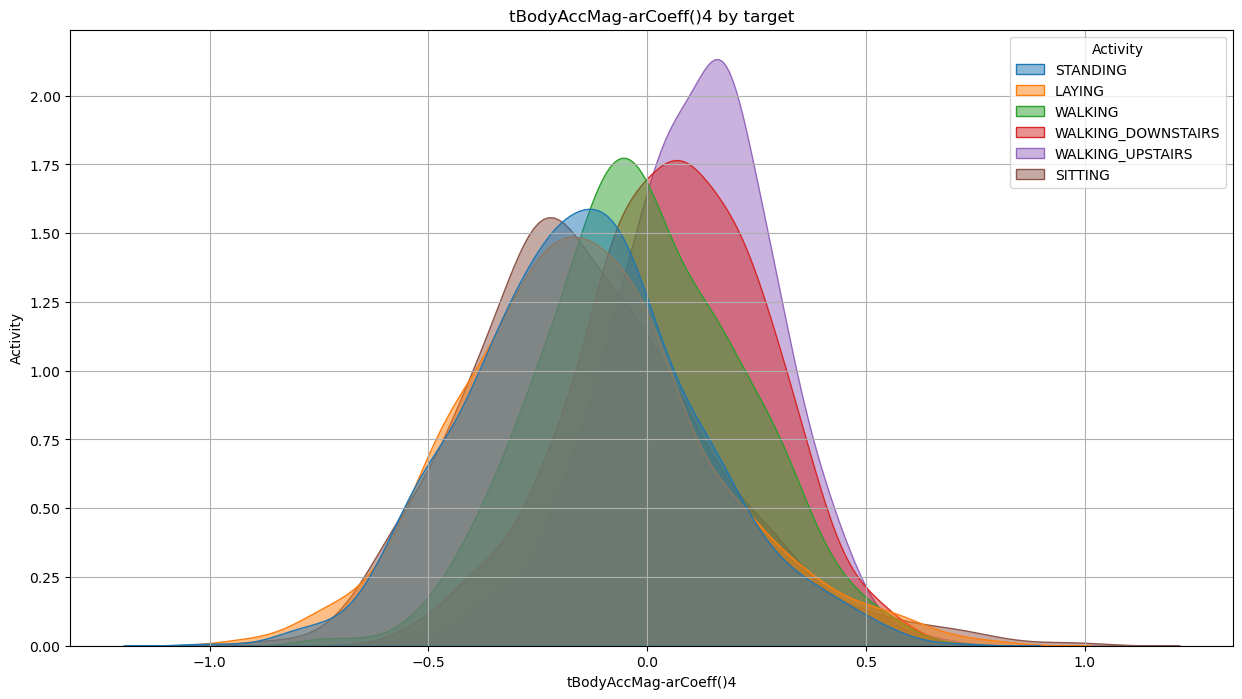

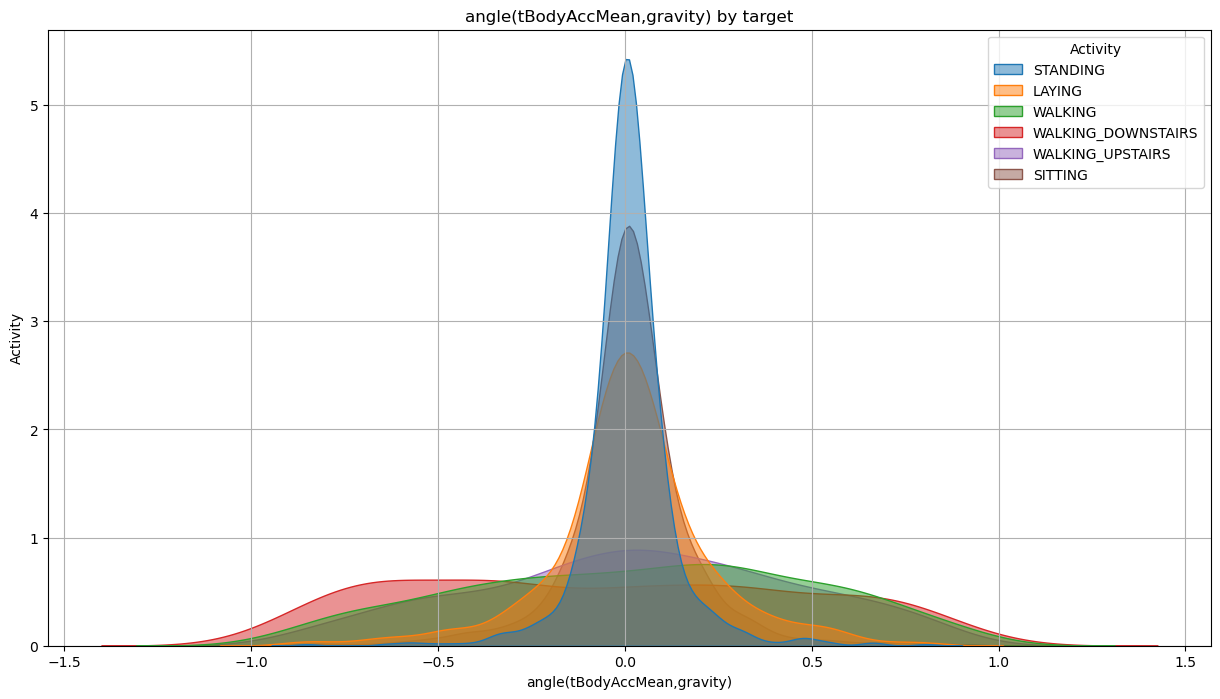

In [263]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in t5['feature_name']:
    plt.figure(figsize=(15, 8))  
    sns.kdeplot(data=x_train, x=feature, hue=y, fill=True, common_norm=False, alpha=0.5)
    plt.title(f'{feature} by target')
    plt.xlabel(feature)
    plt.ylabel('Activity')
    plt.grid()
    plt.show()  

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [288]:
data = pd.read_csv('data01_train.csv')
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


#### 2) 기본모델 생성

In [291]:
data.rename(columns={'Activity' : 'is_dynamic'  }, inplace = True)

In [293]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject',
       'is_dynamic'],
      dtype='object', length=563)

In [295]:
data['is_dynamic'] =  data['is_dynamic'].map({ 'STANDING': 0,'SITTING': 0,'LAYING': 0, # 정적
    'WALKING': 1,'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1}) # 동적

data['is_dynamic'].value_counts()

is_dynamic
0    3234
1    2647
Name: count, dtype: int64

In [297]:
data.drop(columns='subject', inplace = True)

In [299]:
x = data.drop(columns= 'is_dynamic')
y = data.loc[: , 'is_dynamic']

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x,y , test_size= .3)

In [303]:
x_train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-meanFreq()', 'fBodyBodyGyroJerkMag-skewness()',
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=561)

#### 3) 변수중요도 상위 5개 분석

In [305]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier()

model2.fit(x_train, y_train)

RandomForestClassifier()

In [359]:
h5 = plot_feature_importance(model2.feature_importances_, model2.feature_names_in_,result_only=True).head(5)
h5

,feature_name,feature_importance
0,fBodyAccJerk-std()-X,0.050000
1,"fBodyAccJerk-bandsEnergy()-1,24",0.049980
2,tBodyAccJerk-std()-X,0.049931
3,"fBodyAccJerk-bandsEnergy()-1,8",0.040075
4,fBodyAccJerk-max()-X,0.040014


In [363]:
h5.feature_name

0               fBodyAccJerk-std()-X
1    fBodyAccJerk-bandsEnergy()-1,24
2               tBodyAccJerk-std()-X
3     fBodyAccJerk-bandsEnergy()-1,8
4               fBodyAccJerk-max()-X
Name: feature_name, dtype: object

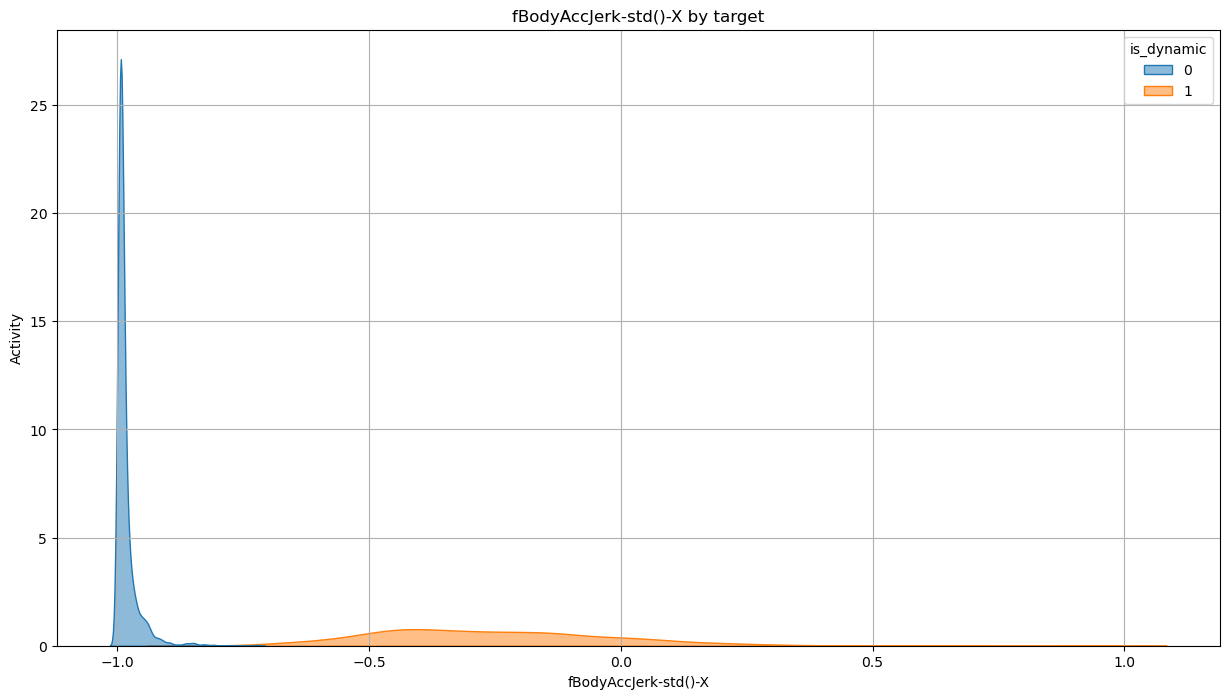

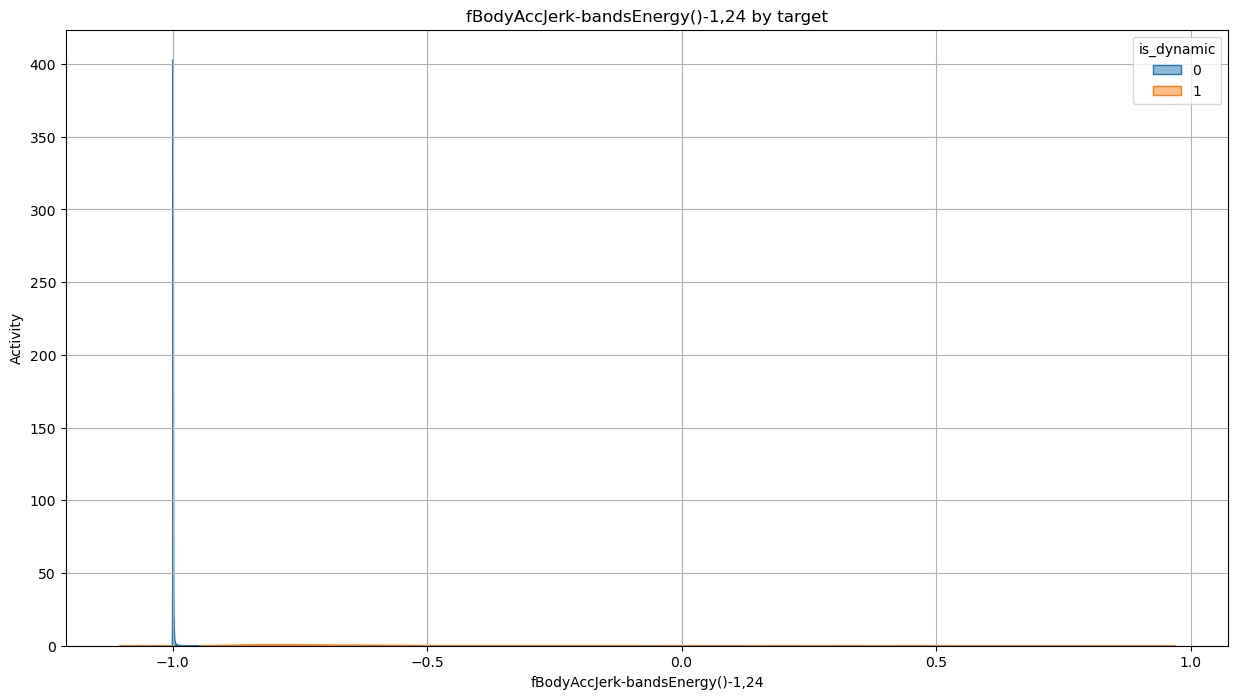

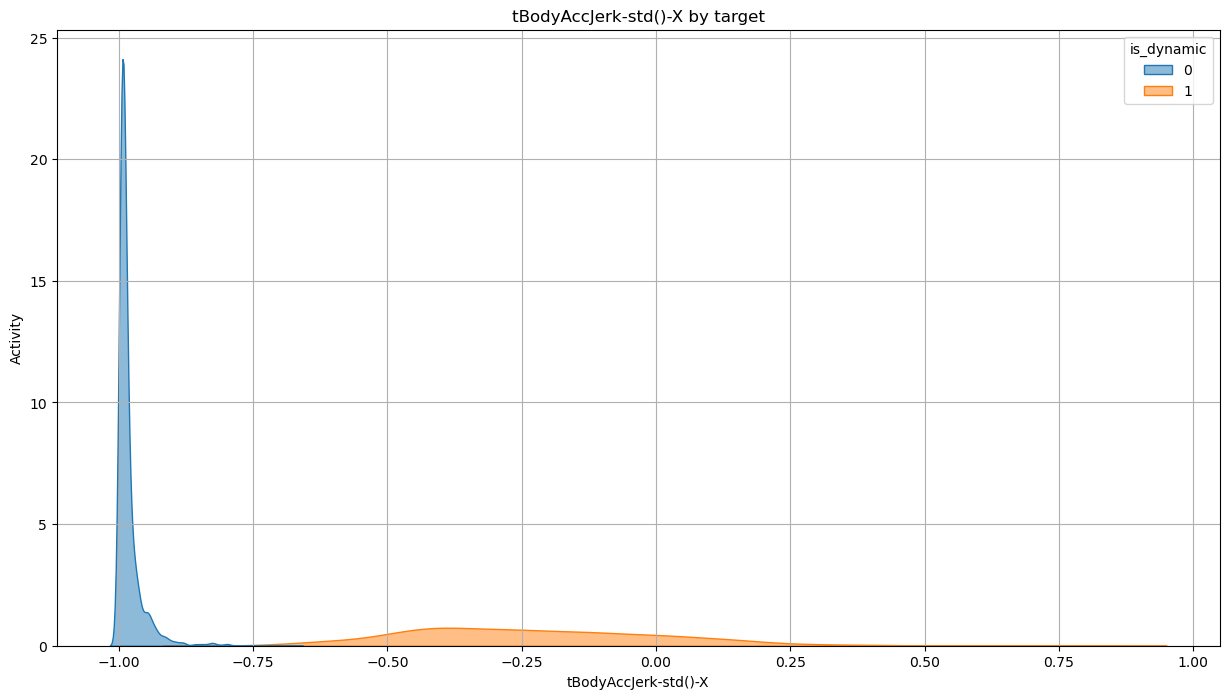

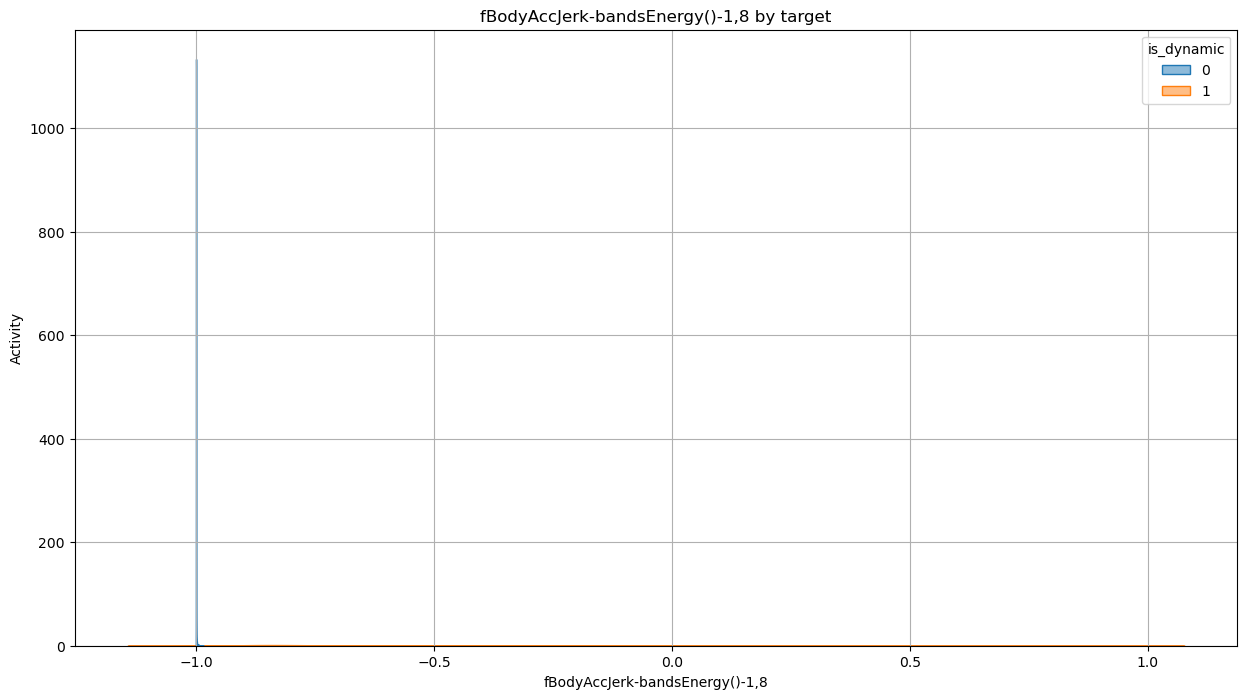

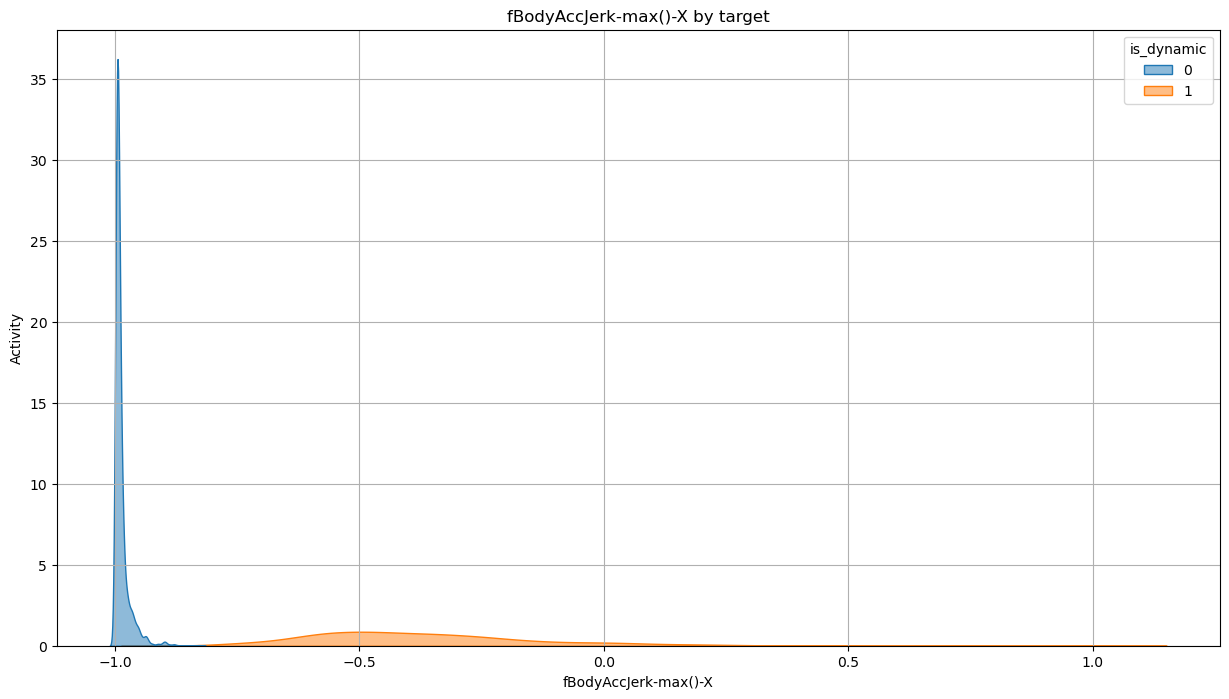

In [383]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in h5.feature_name:
    plt.figure(figsize=(15, 8))  
    sns.kdeplot(data=x_train, x=feature, hue=y, fill = True, common_norm=True, alpha=0.5)
    plt.title(f'{feature} by target')
    plt.xlabel(feature)
    plt.ylabel('Activity')
    plt.grid()
    plt.show()  

In [490]:
group_acc = x_train.loc[:, x_train.columns.str.contains('Acc')]
group_gyro = x_train.loc[:, x_train.columns.str.contains('Gyro')]

In [492]:
group_acc_val = x_val.loc[:, x_val.columns.str.contains('Acc')]
group_gyro_val = x_val.loc[:, x_val.columns.str.contains('Gyro')]

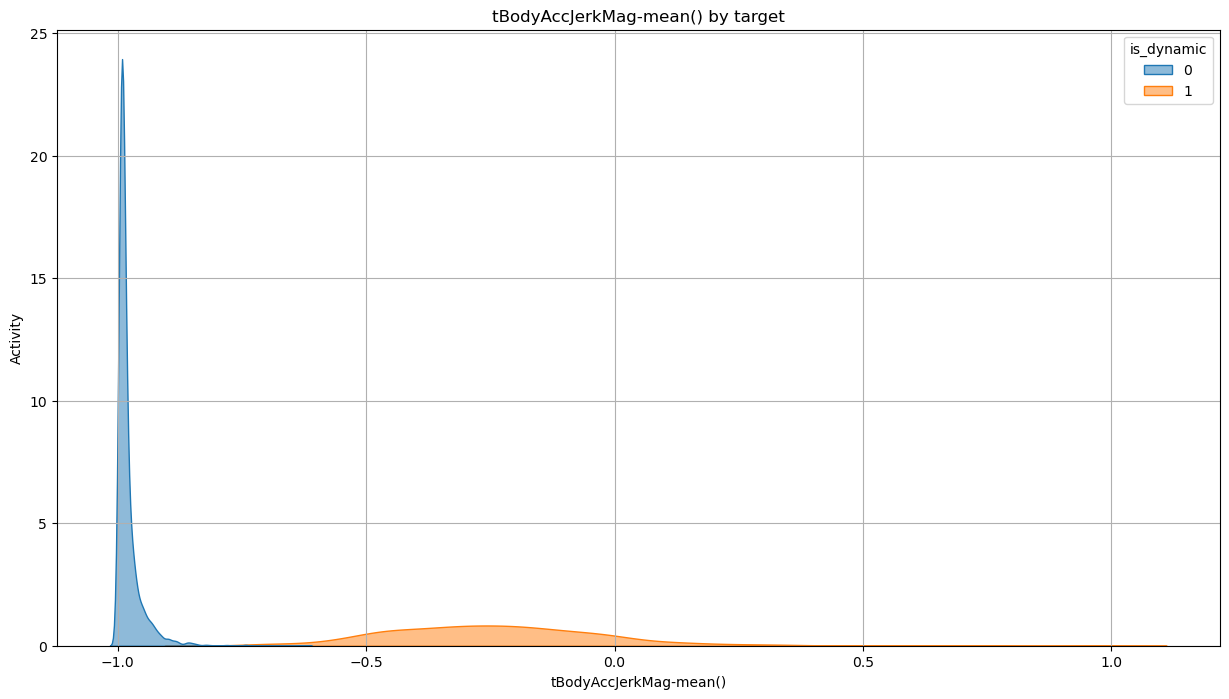

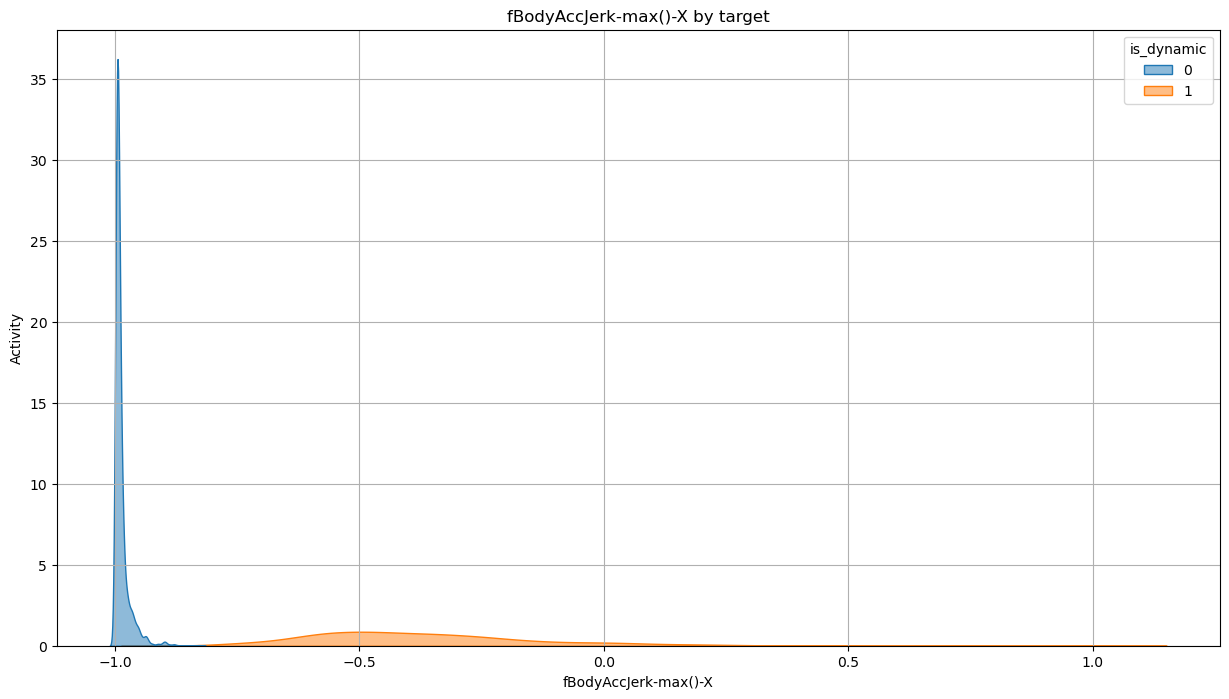

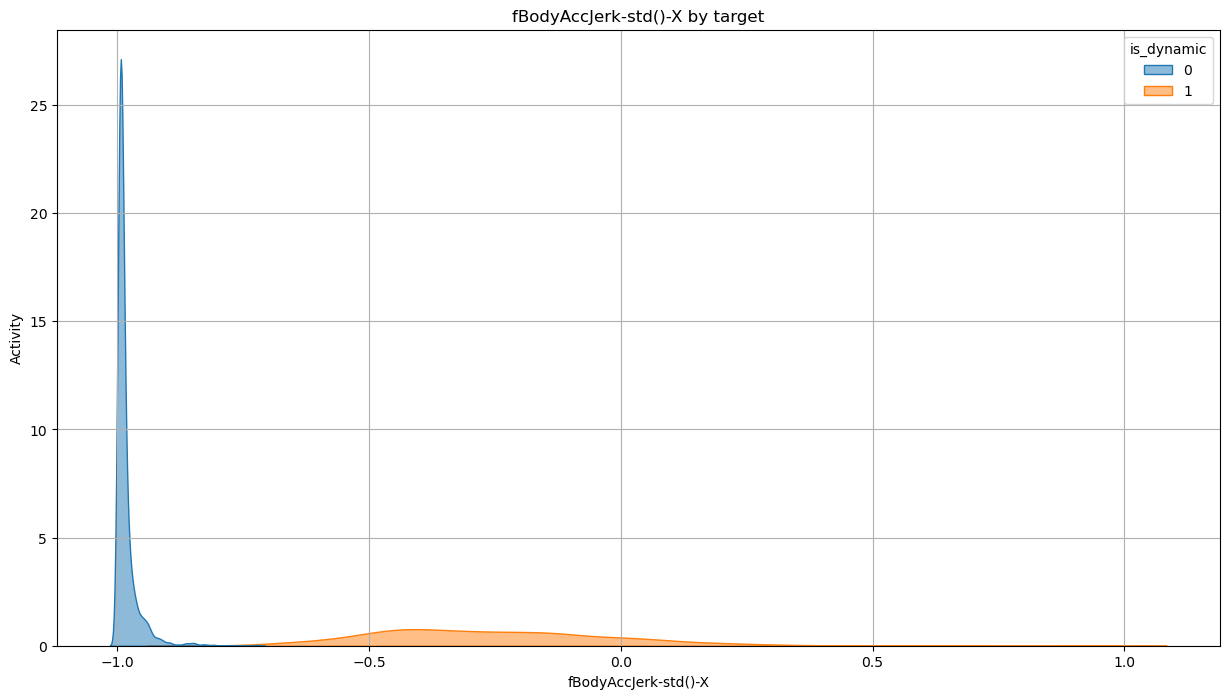

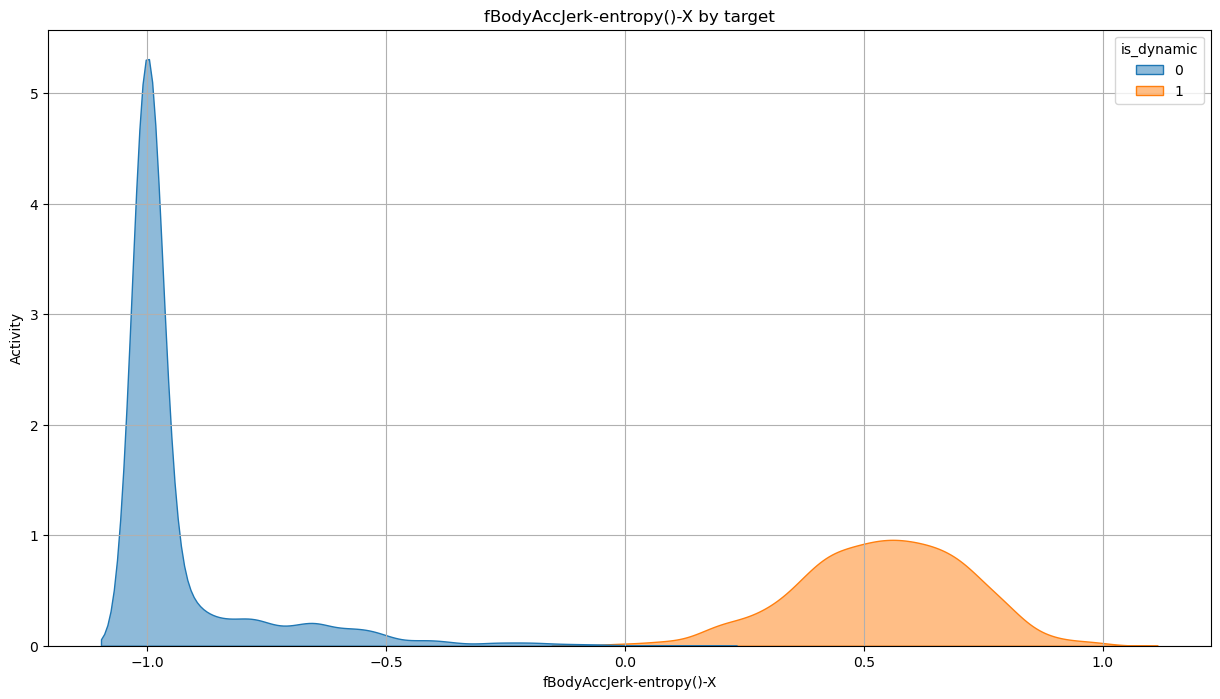

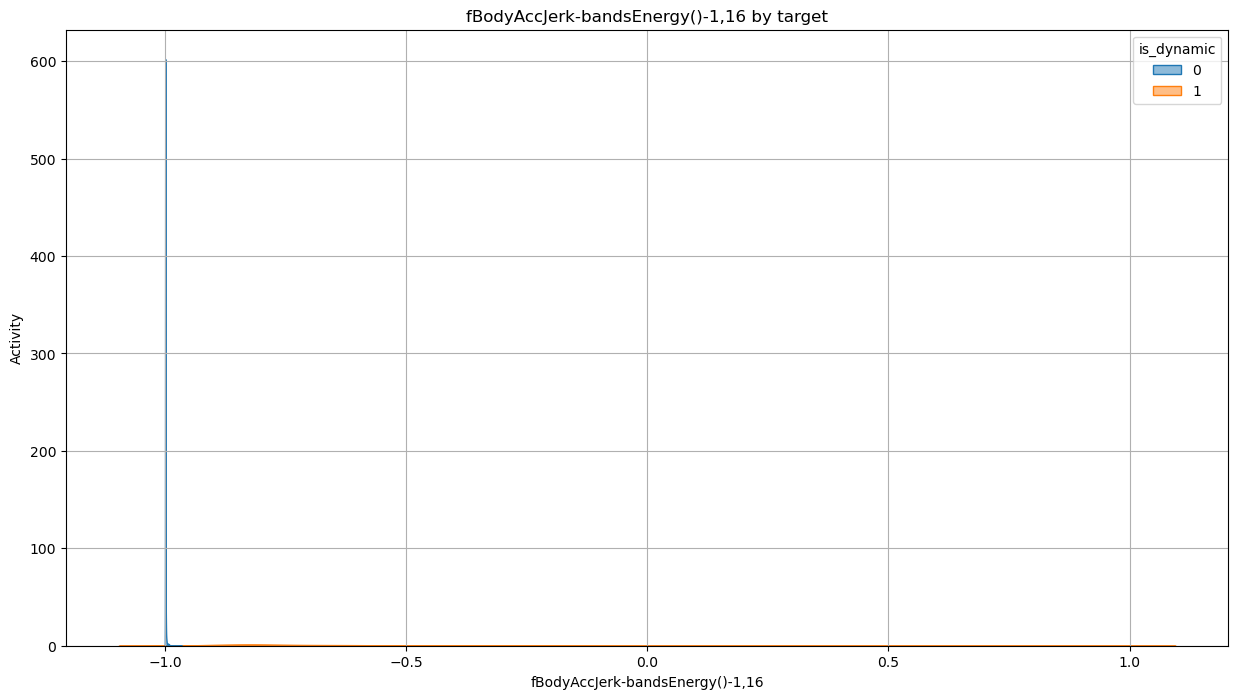

[[950   1]
 [  0 814]]


In [494]:
model3 = RandomForestClassifier()

model3.fit(group_acc, y_train)

Acc_h5 = plot_feature_importance(model3.feature_importances_,
                                 model3.feature_names_in_,
                                 result_only=True)


for feature in Acc_h5.feature_name[:5]:
    plt.figure(figsize=(15, 8))  
    sns.kdeplot(data=group_acc, x=feature, hue=y_train, fill = True, common_norm=True, alpha=0.5)
    plt.title(f'{feature} by target')
    plt.xlabel(feature)
    plt.ylabel('Activity')
    plt.grid()
    plt.show()  


pred_acc = model3.predict(group_acc_val)
print(confusion_matrix(y_val, pred_acc))
    
# Acc 계열의 센서는 동적은 동작보다 정적인 동적을 잘 구분한다.

In [508]:
Acc_h5[Acc_h5['feature_importance'] == 0]

,feature_name,feature_importance
113,"fBodyAcc-bandsEnergy()-17,24.1",0.0
114,"fBodyAcc-bandsEnergy()-49,64.1",0.0
115,"fBodyAcc-bandsEnergy()-1,8.2",0.0
116,"fBodyAcc-bandsEnergy()-25,48.1",0.0
117,"fBodyAcc-bandsEnergy()-1,24.1",0.0
...,...,...
340,tBodyAccJerkMag-arCoeff()3,0.0
341,tBodyAccJerkMag-arCoeff()4,0.0
342,fBodyAcc-mean()-Y,0.0
343,fBodyAcc-mean()-Z,0.0


In [510]:
Gyro_h5[Gyro_h5['feature_importance'] == 0]

,feature_name,feature_importance
152,tBodyGyro-entropy()-X,0.0
153,tBodyGyroMag-arCoeff()2,0.0
154,fBodyBodyGyroMag-energy(),0.0
155,"tBodyGyro-arCoeff()-Z,2",0.0
156,tBodyGyroMag-std(),0.0
...,...,...
208,"fBodyGyro-bandsEnergy()-33,40.2",0.0
209,fBodyGyro-maxInds-Y,0.0
210,fBodyGyro-kurtosis()-Z,0.0
211,"fBodyGyro-bandsEnergy()-57,64.2",0.0


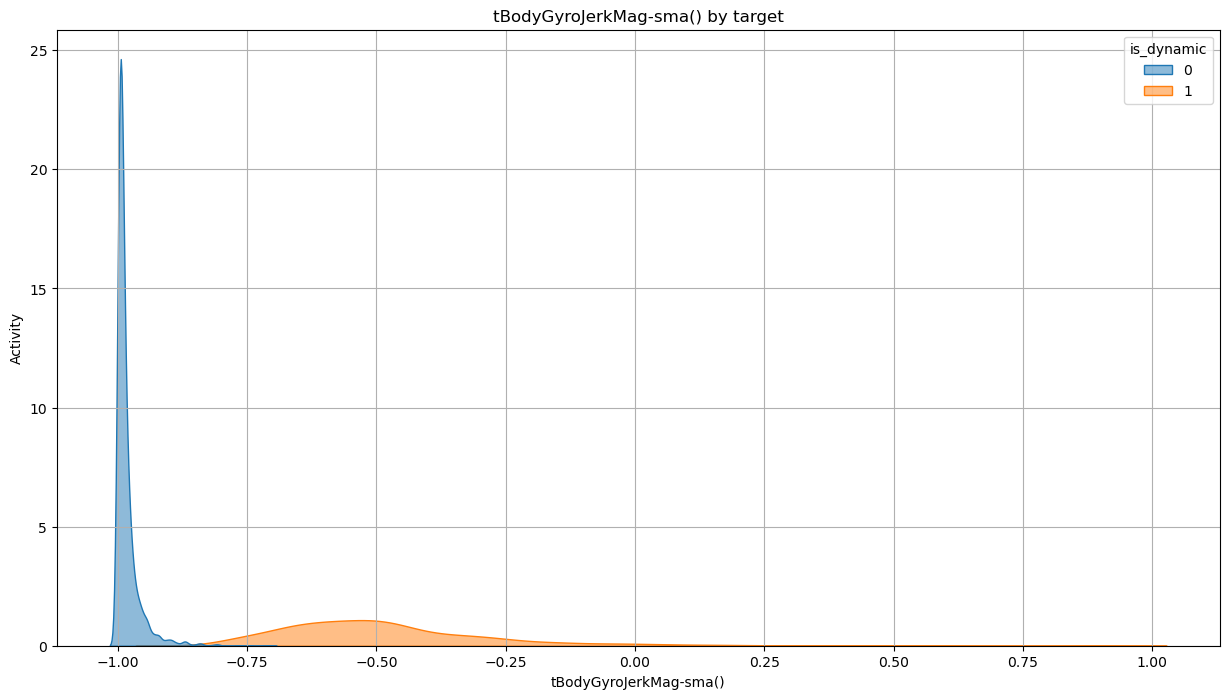

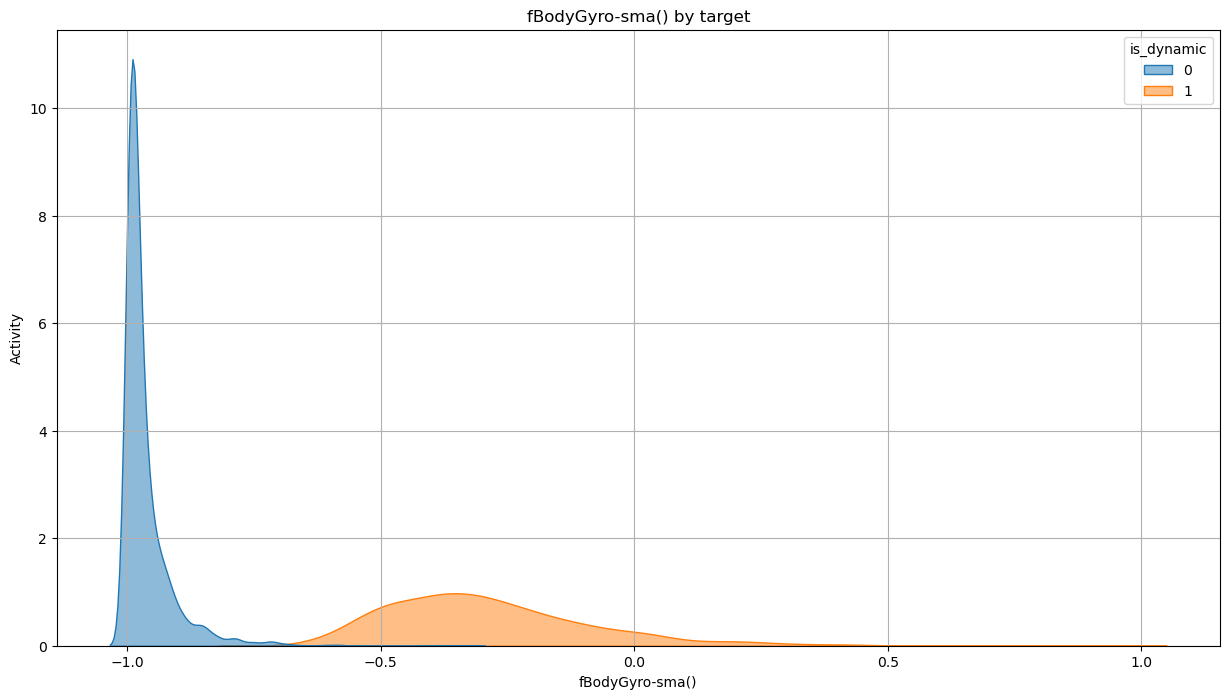

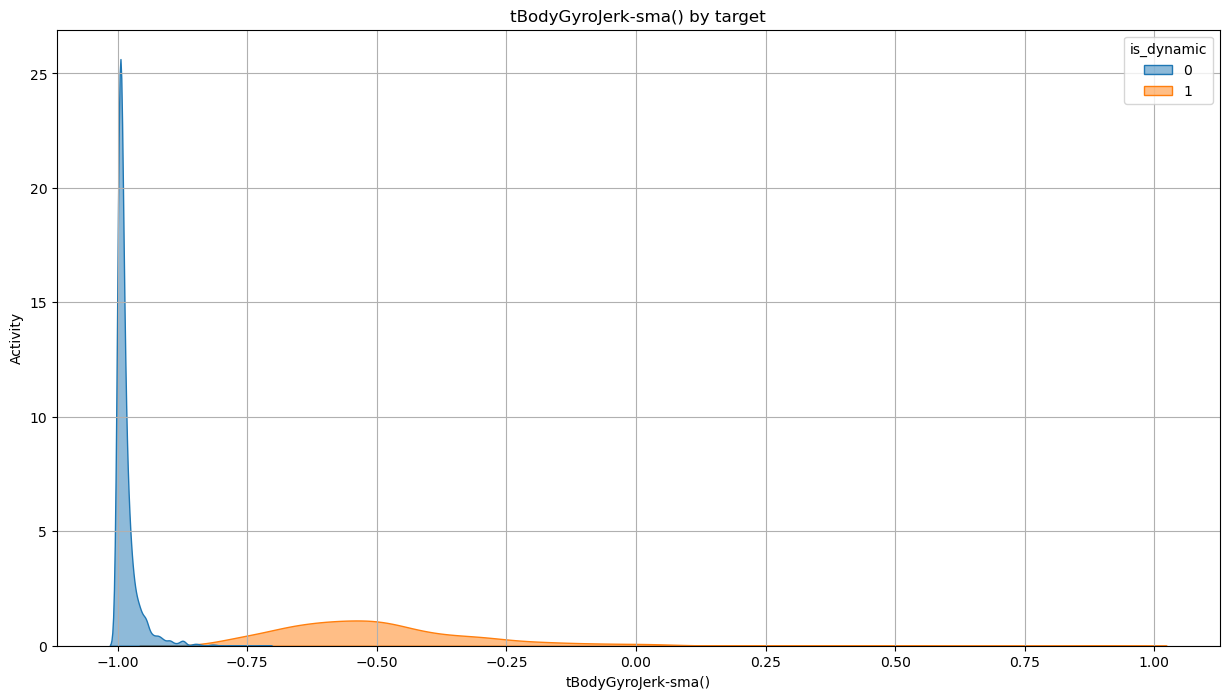

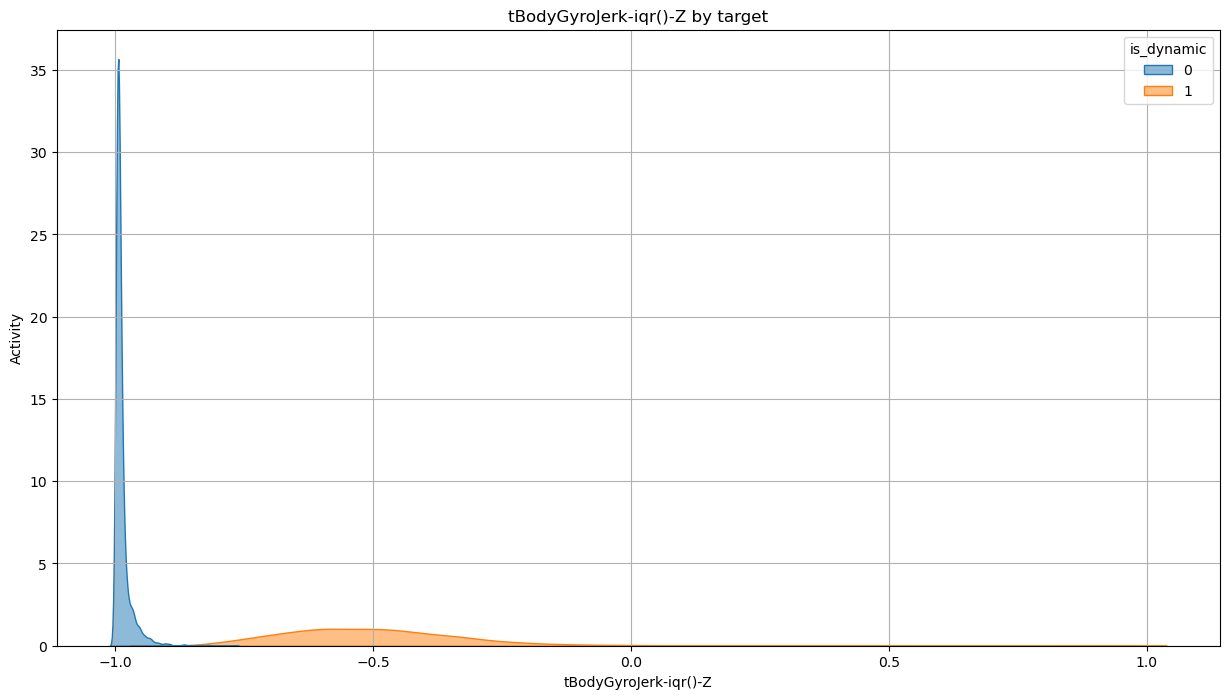

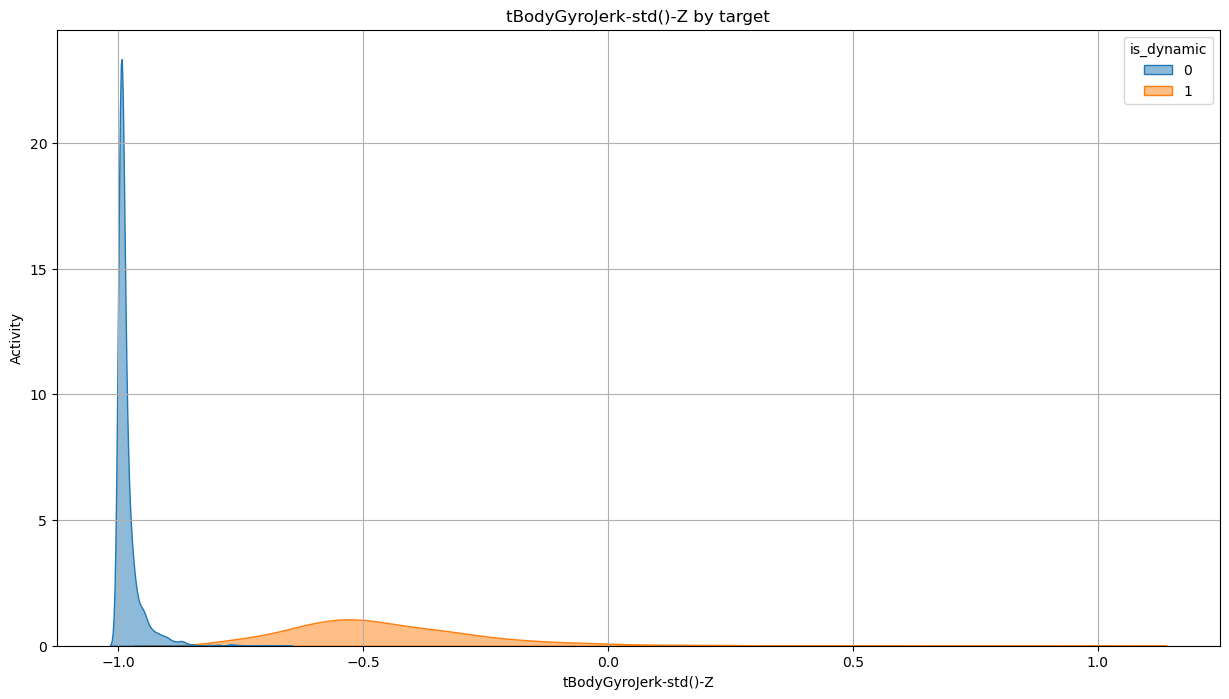

[[950   1]
 [  0 814]]


In [496]:
model4 = RandomForestClassifier()

model4.fit(group_gyro, y_train)

Gyro_h5 = plot_feature_importance(model4.feature_importances_,
                                 model4.feature_names_in_,
                                 result_only=True)


for feature in Gyro_h5.feature_name[:5]:
    plt.figure(figsize=(15, 8))  
    sns.kdeplot(data=group_gyro, x=feature, hue=y_train, fill = True, common_norm=True, alpha=0.5)
    plt.title(f'{feature} by target')
    plt.xlabel(feature)
    plt.ylabel('Activity')
    plt.grid()
    plt.show()  

pred_gyro = model4.predict(group_gyro_val)
print(confusion_matrix(y_val, pred_gyro))

In [498]:
Gyro_h5

,feature_name,feature_importance
0,tBodyGyroJerkMag-sma(),0.119179
1,fBodyGyro-sma(),0.099429
2,tBodyGyroJerk-sma(),0.069870
3,tBodyGyroJerk-iqr()-Z,0.060531
4,tBodyGyroJerk-std()-Z,0.059375
...,...,...
208,"fBodyGyro-bandsEnergy()-33,40.2",0.000000
209,fBodyGyro-maxInds-Y,0.000000
210,fBodyGyro-kurtosis()-Z,0.000000
211,"fBodyGyro-bandsEnergy()-57,64.2",0.000000


- is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
-  is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
-   sensor별
-   sensor+agg 별

- # 피쳐 갯수 줄이기
- 변수중요도 0 제거 (294개)
- 상위 몇개만 사용
- 상관계수 특정 값 이하 변수 제거
- 클래스의 변수중요도 사용


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

#### 2) 합치기

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.